In [1]:
import os
import pickle
import numpy as np
import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
import umap.plot

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
niter = 3

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.edr.hiz.sa1p5sb1p5.i%i.pt' % niter)

specs, recon, true_cont = [], [], []
redshifts, weights, tids, norms, latents = [], [], [], [], []
for ibatch in range(50): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    specs.append(np.array(spec))
    tids.append(np.array(target_id))
    norms.append(np.array(norm))
    redshifts.append(np.array(z))
    weights.append(np.array(w))
    
    # latents
    latents.append(np.load('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.latents.npy' % (niter, ibatch)))

    # load SpenderQ recon 
    recon.append(np.load('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.recons.npy' % (niter, ibatch)))
    
specs = np.concatenate(specs, axis=0)
tids = np.concatenate(tids)
norms = np.concatenate(norms)
redshifts = np.concatenate(redshifts)
weights = np.concatenate(weights, axis=0)
latents = np.concatenate(latents)

recon = np.concatenate(recon, axis=0)

w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)
/tmp/ipyke

# latents

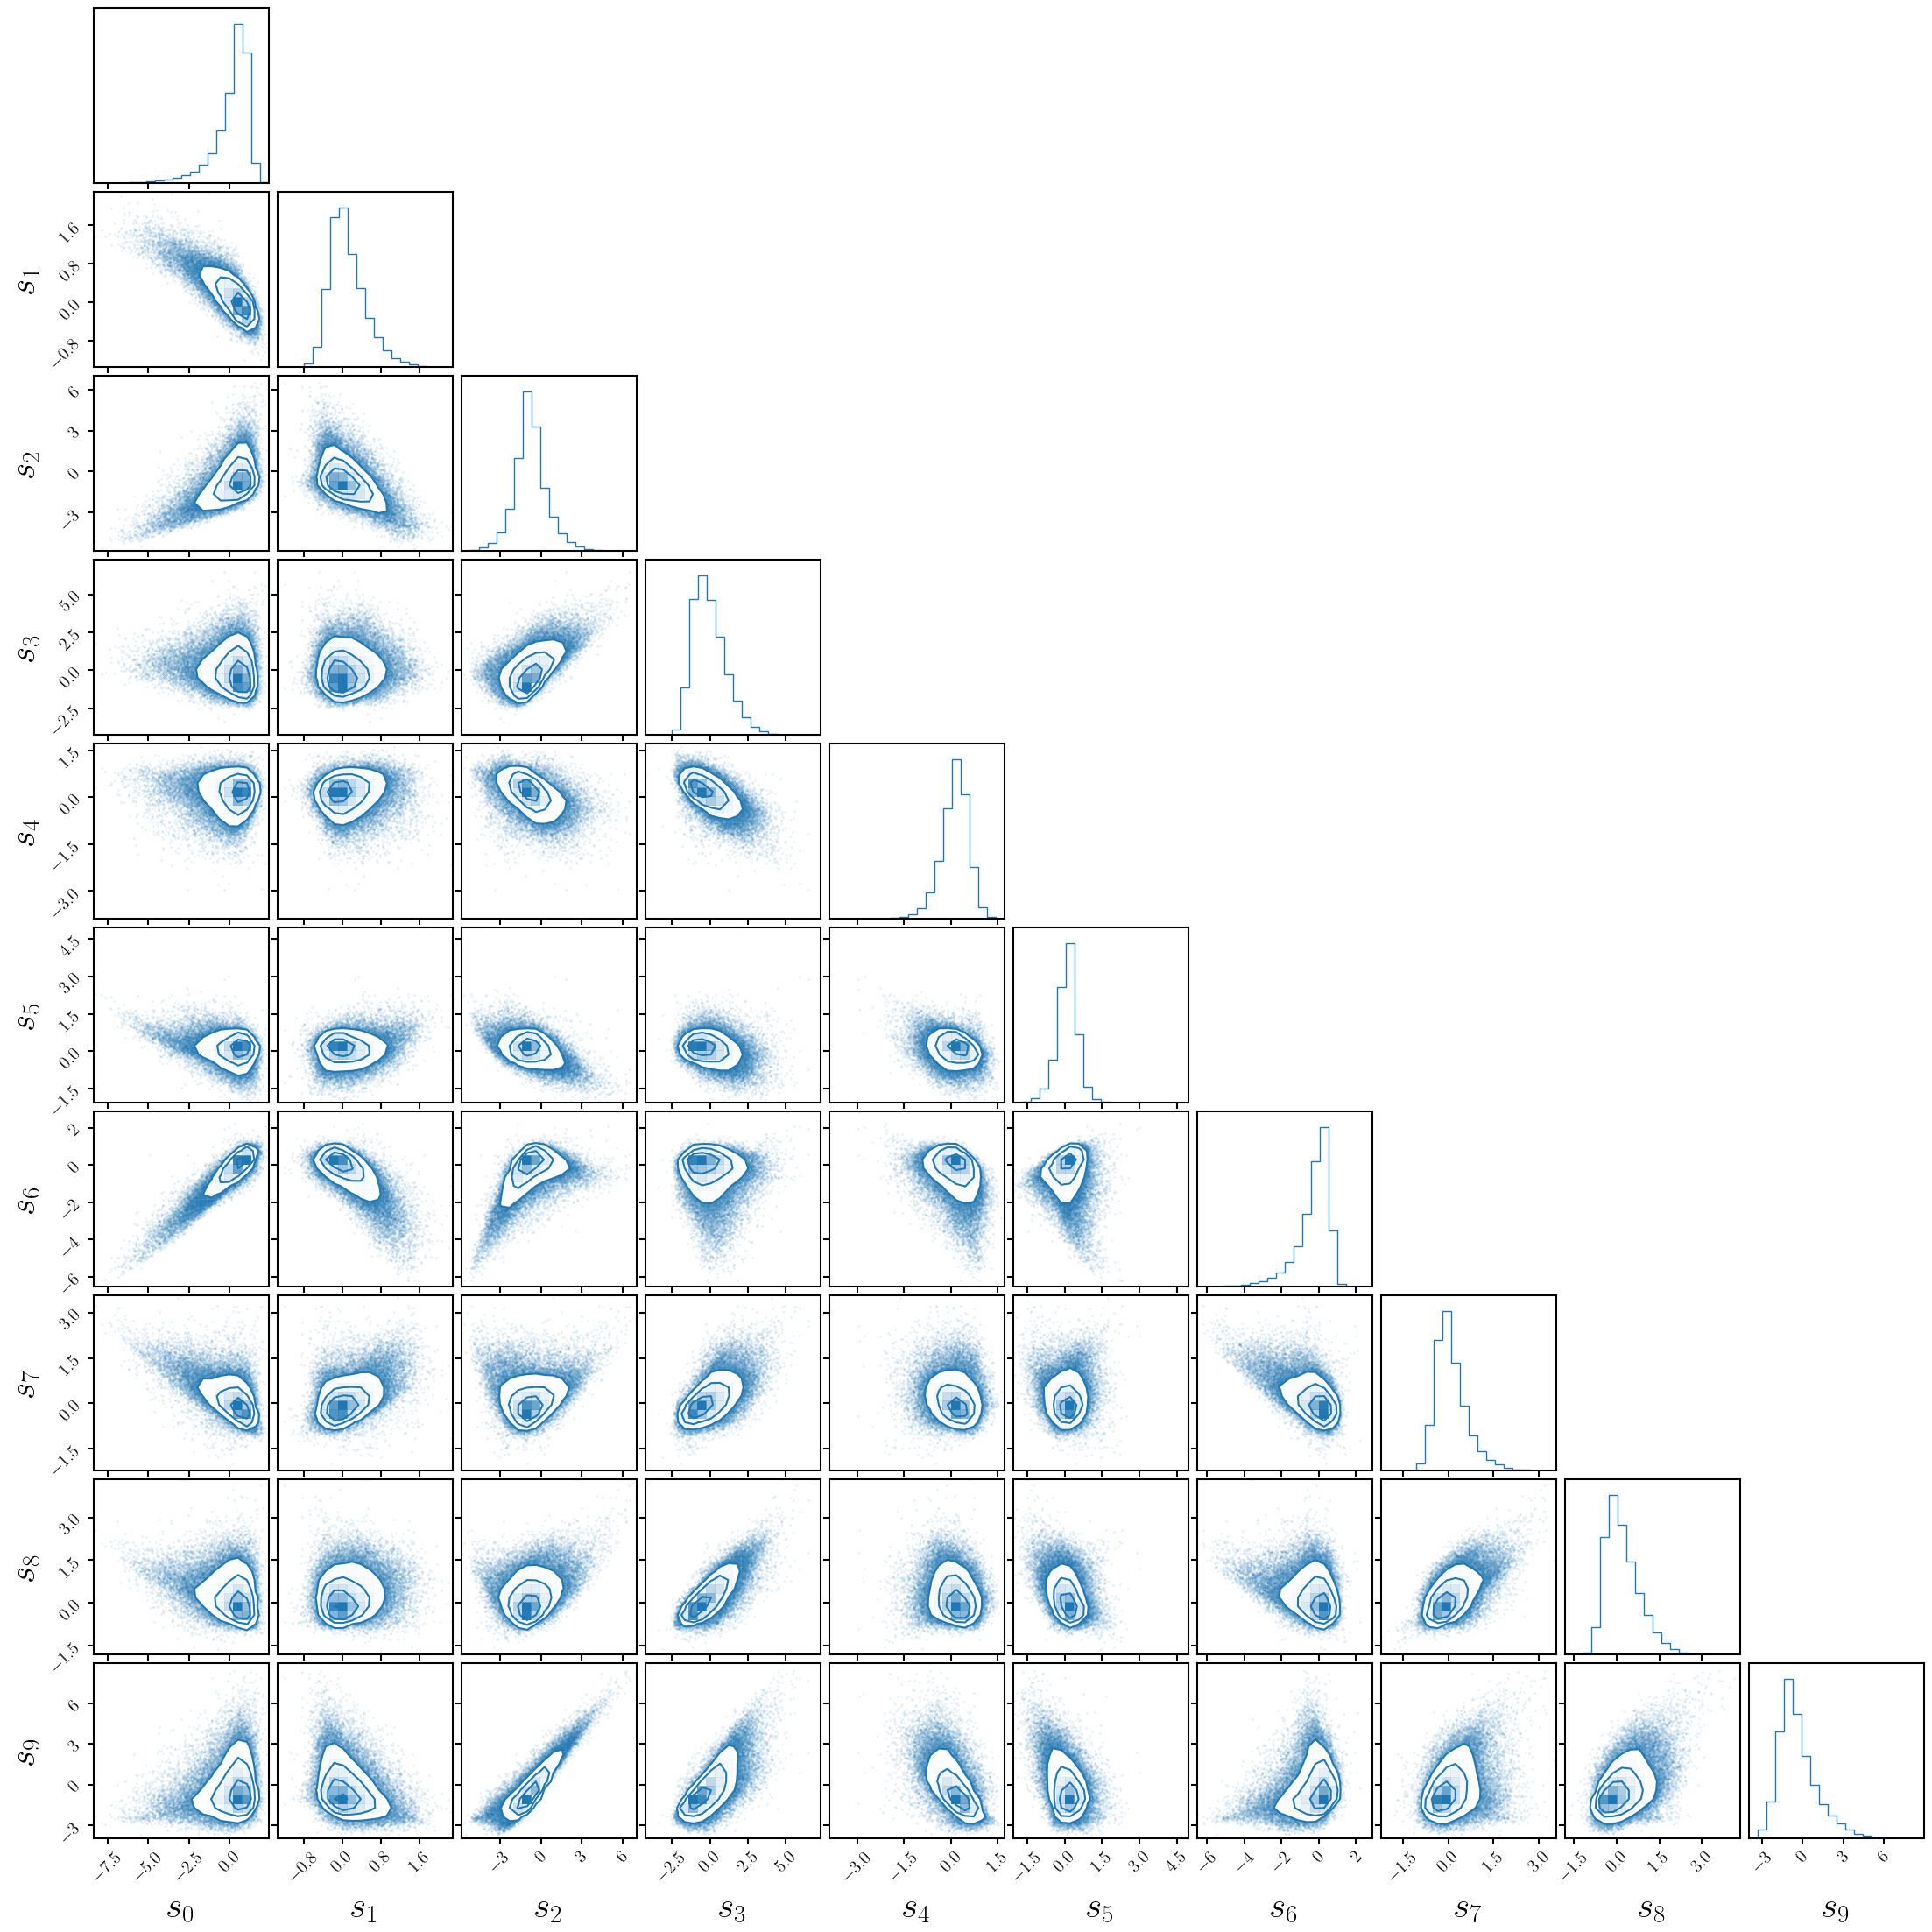

In [5]:
fig = DFM.corner(latents, color='C0',
                 labels=[r'$s_{%i}$' % i for i in range(latents.shape[1])],
                 label_kwargs={'fontsize': 30})

In [6]:
s_low, s_high = np.quantile(latents, (0.00001, 0.99999), axis=0)

outliers = np.zeros(latents.shape[0]).astype(bool)
for i in range(latents.shape[1]): 
    outliers = outliers | (latents[:,i] < s_low[i]) | (latents[:,i] > s_high[i])
print(np.sum(outliers))

13


In [7]:
d_outliers = np.sum((latents[outliers] - np.median(latents, axis=0))**2, axis=1)

most_outliers = np.arange(latents.shape[0])[outliers][np.argsort(d_outliers)[::-1][:10]]

In [8]:
tids[most_outliers]

array([39628243527012437, 39633463514499370, 39628512734218381,
       39632945203381785, 39633282660302938, 39628302146603290,
       39628506174327232, 39633091861416765, 39628216733794884,
       39628135402046158])

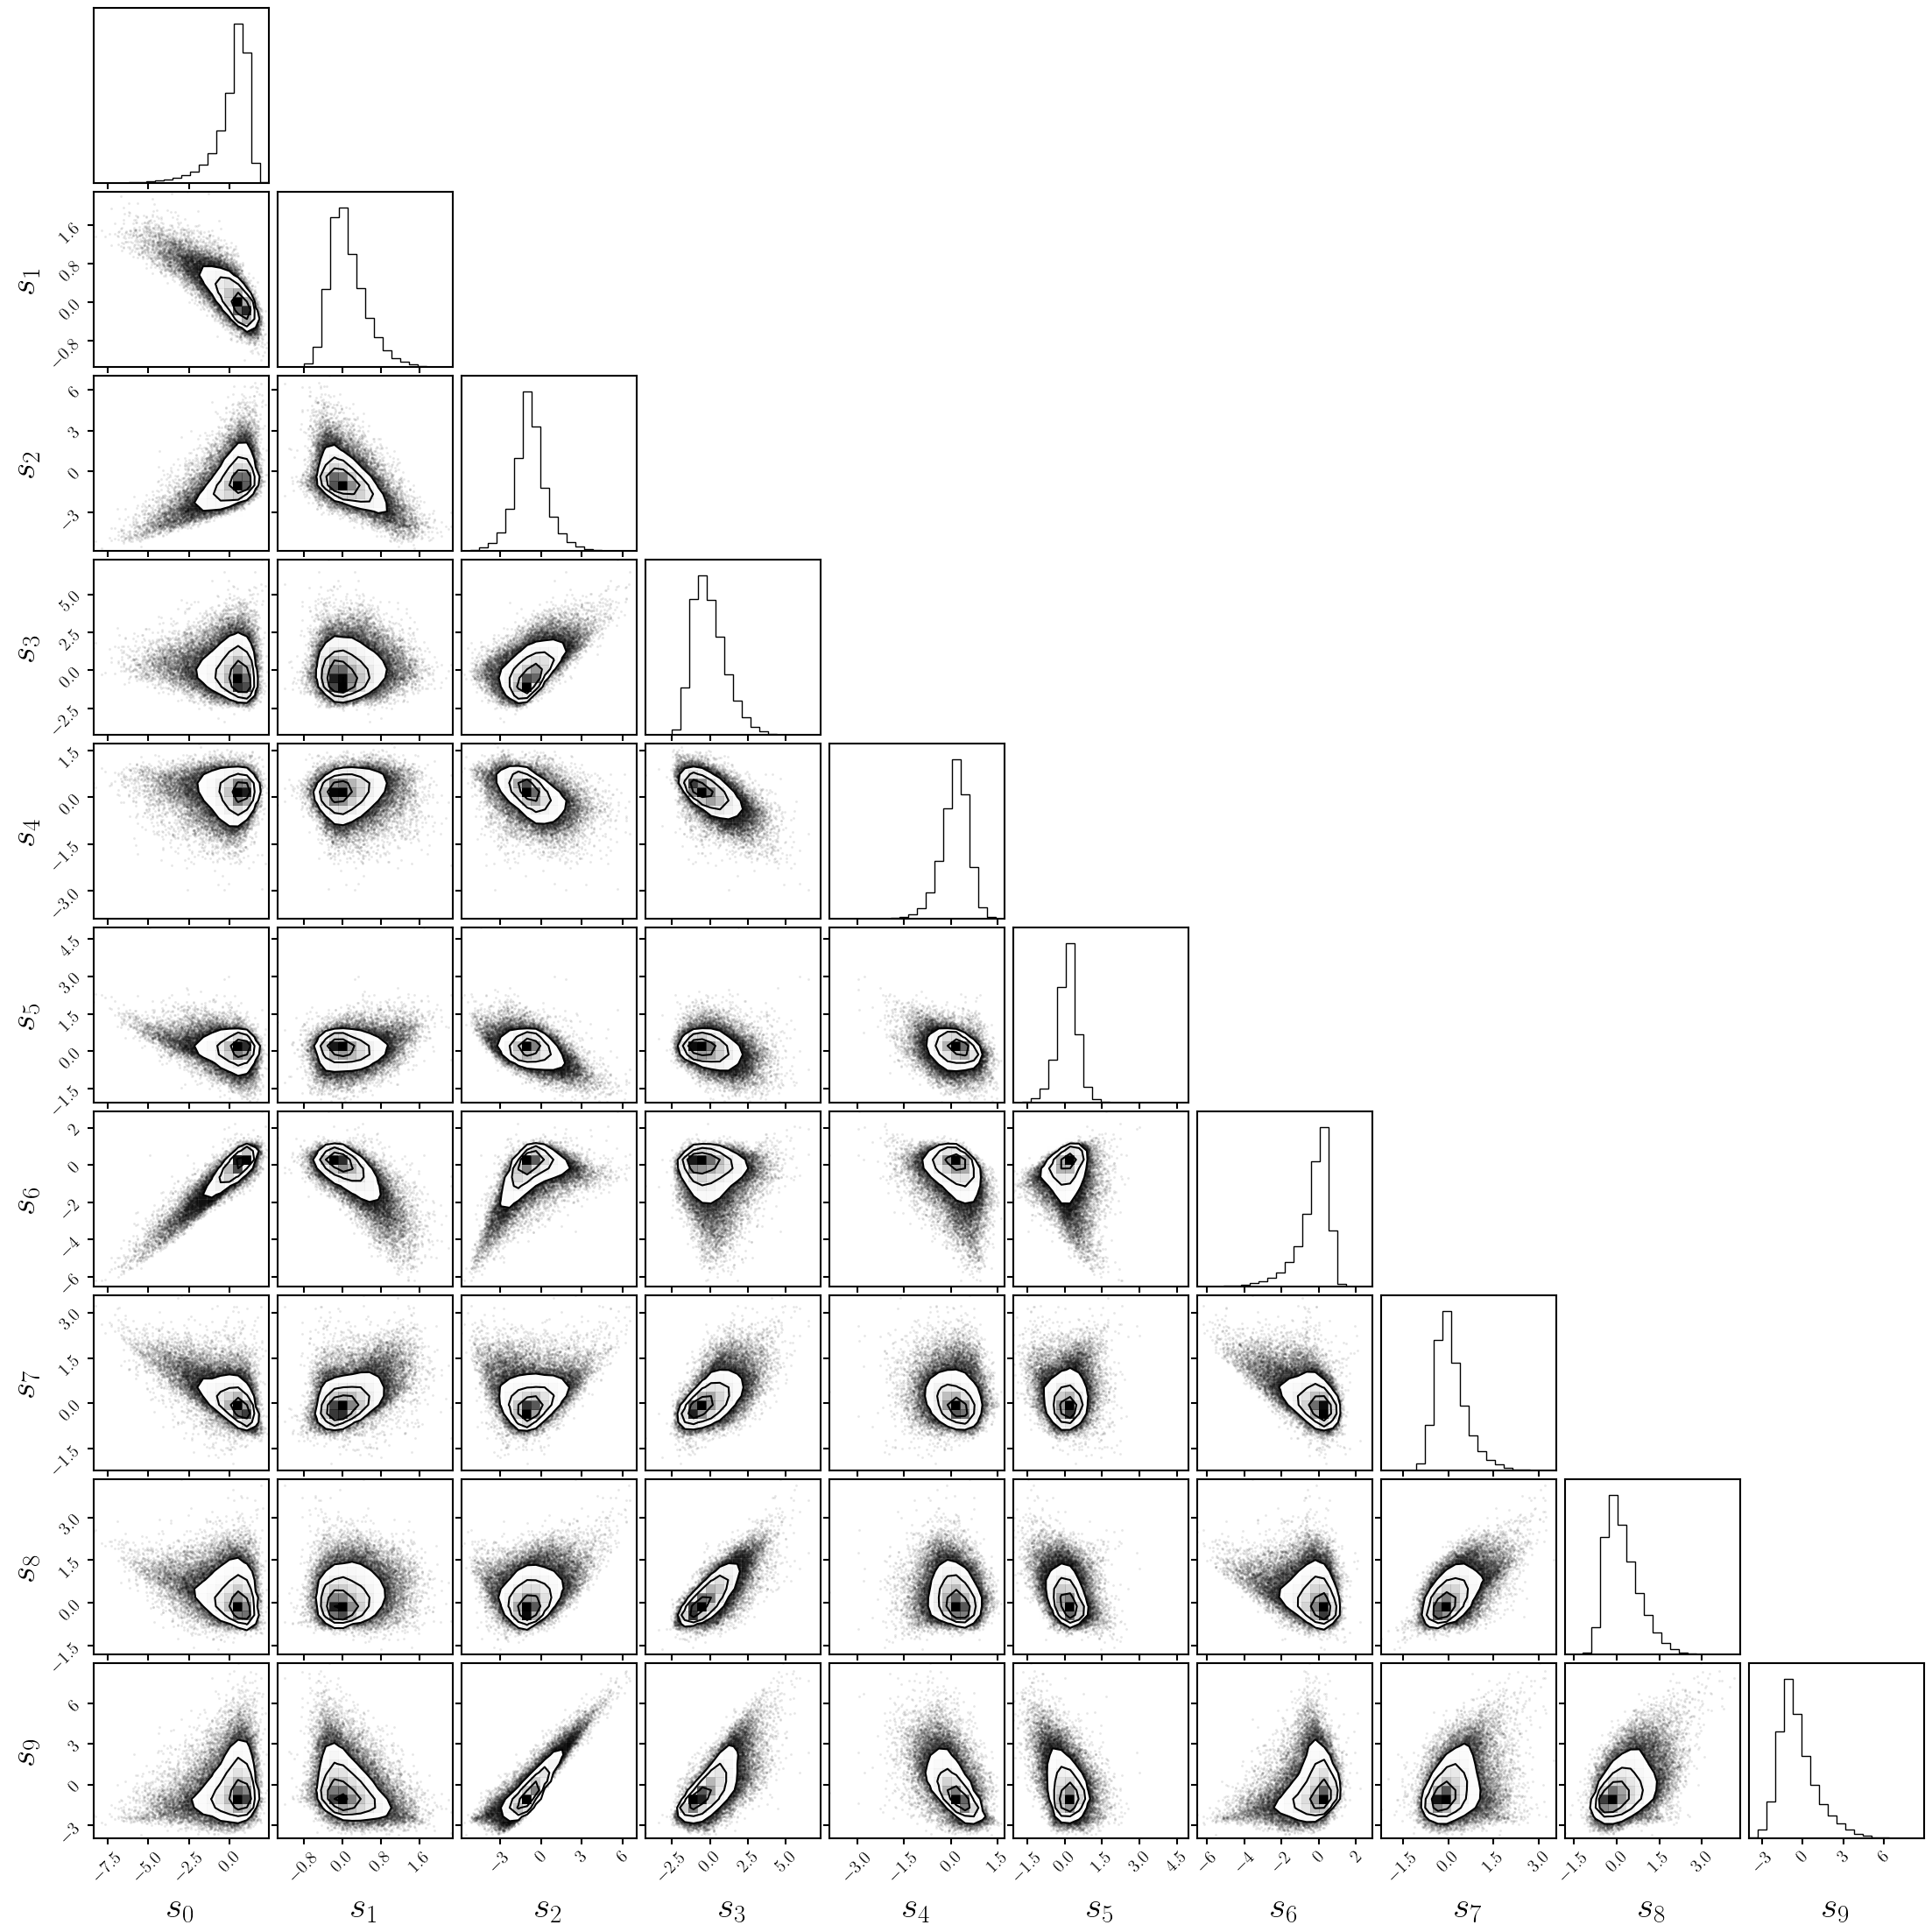

In [9]:
fig = DFM.corner(latents, color='k',
                 labels=[r'$s_{%i}$' % i for i in range(latents.shape[1])],
                 label_kwargs={'fontsize': 30})

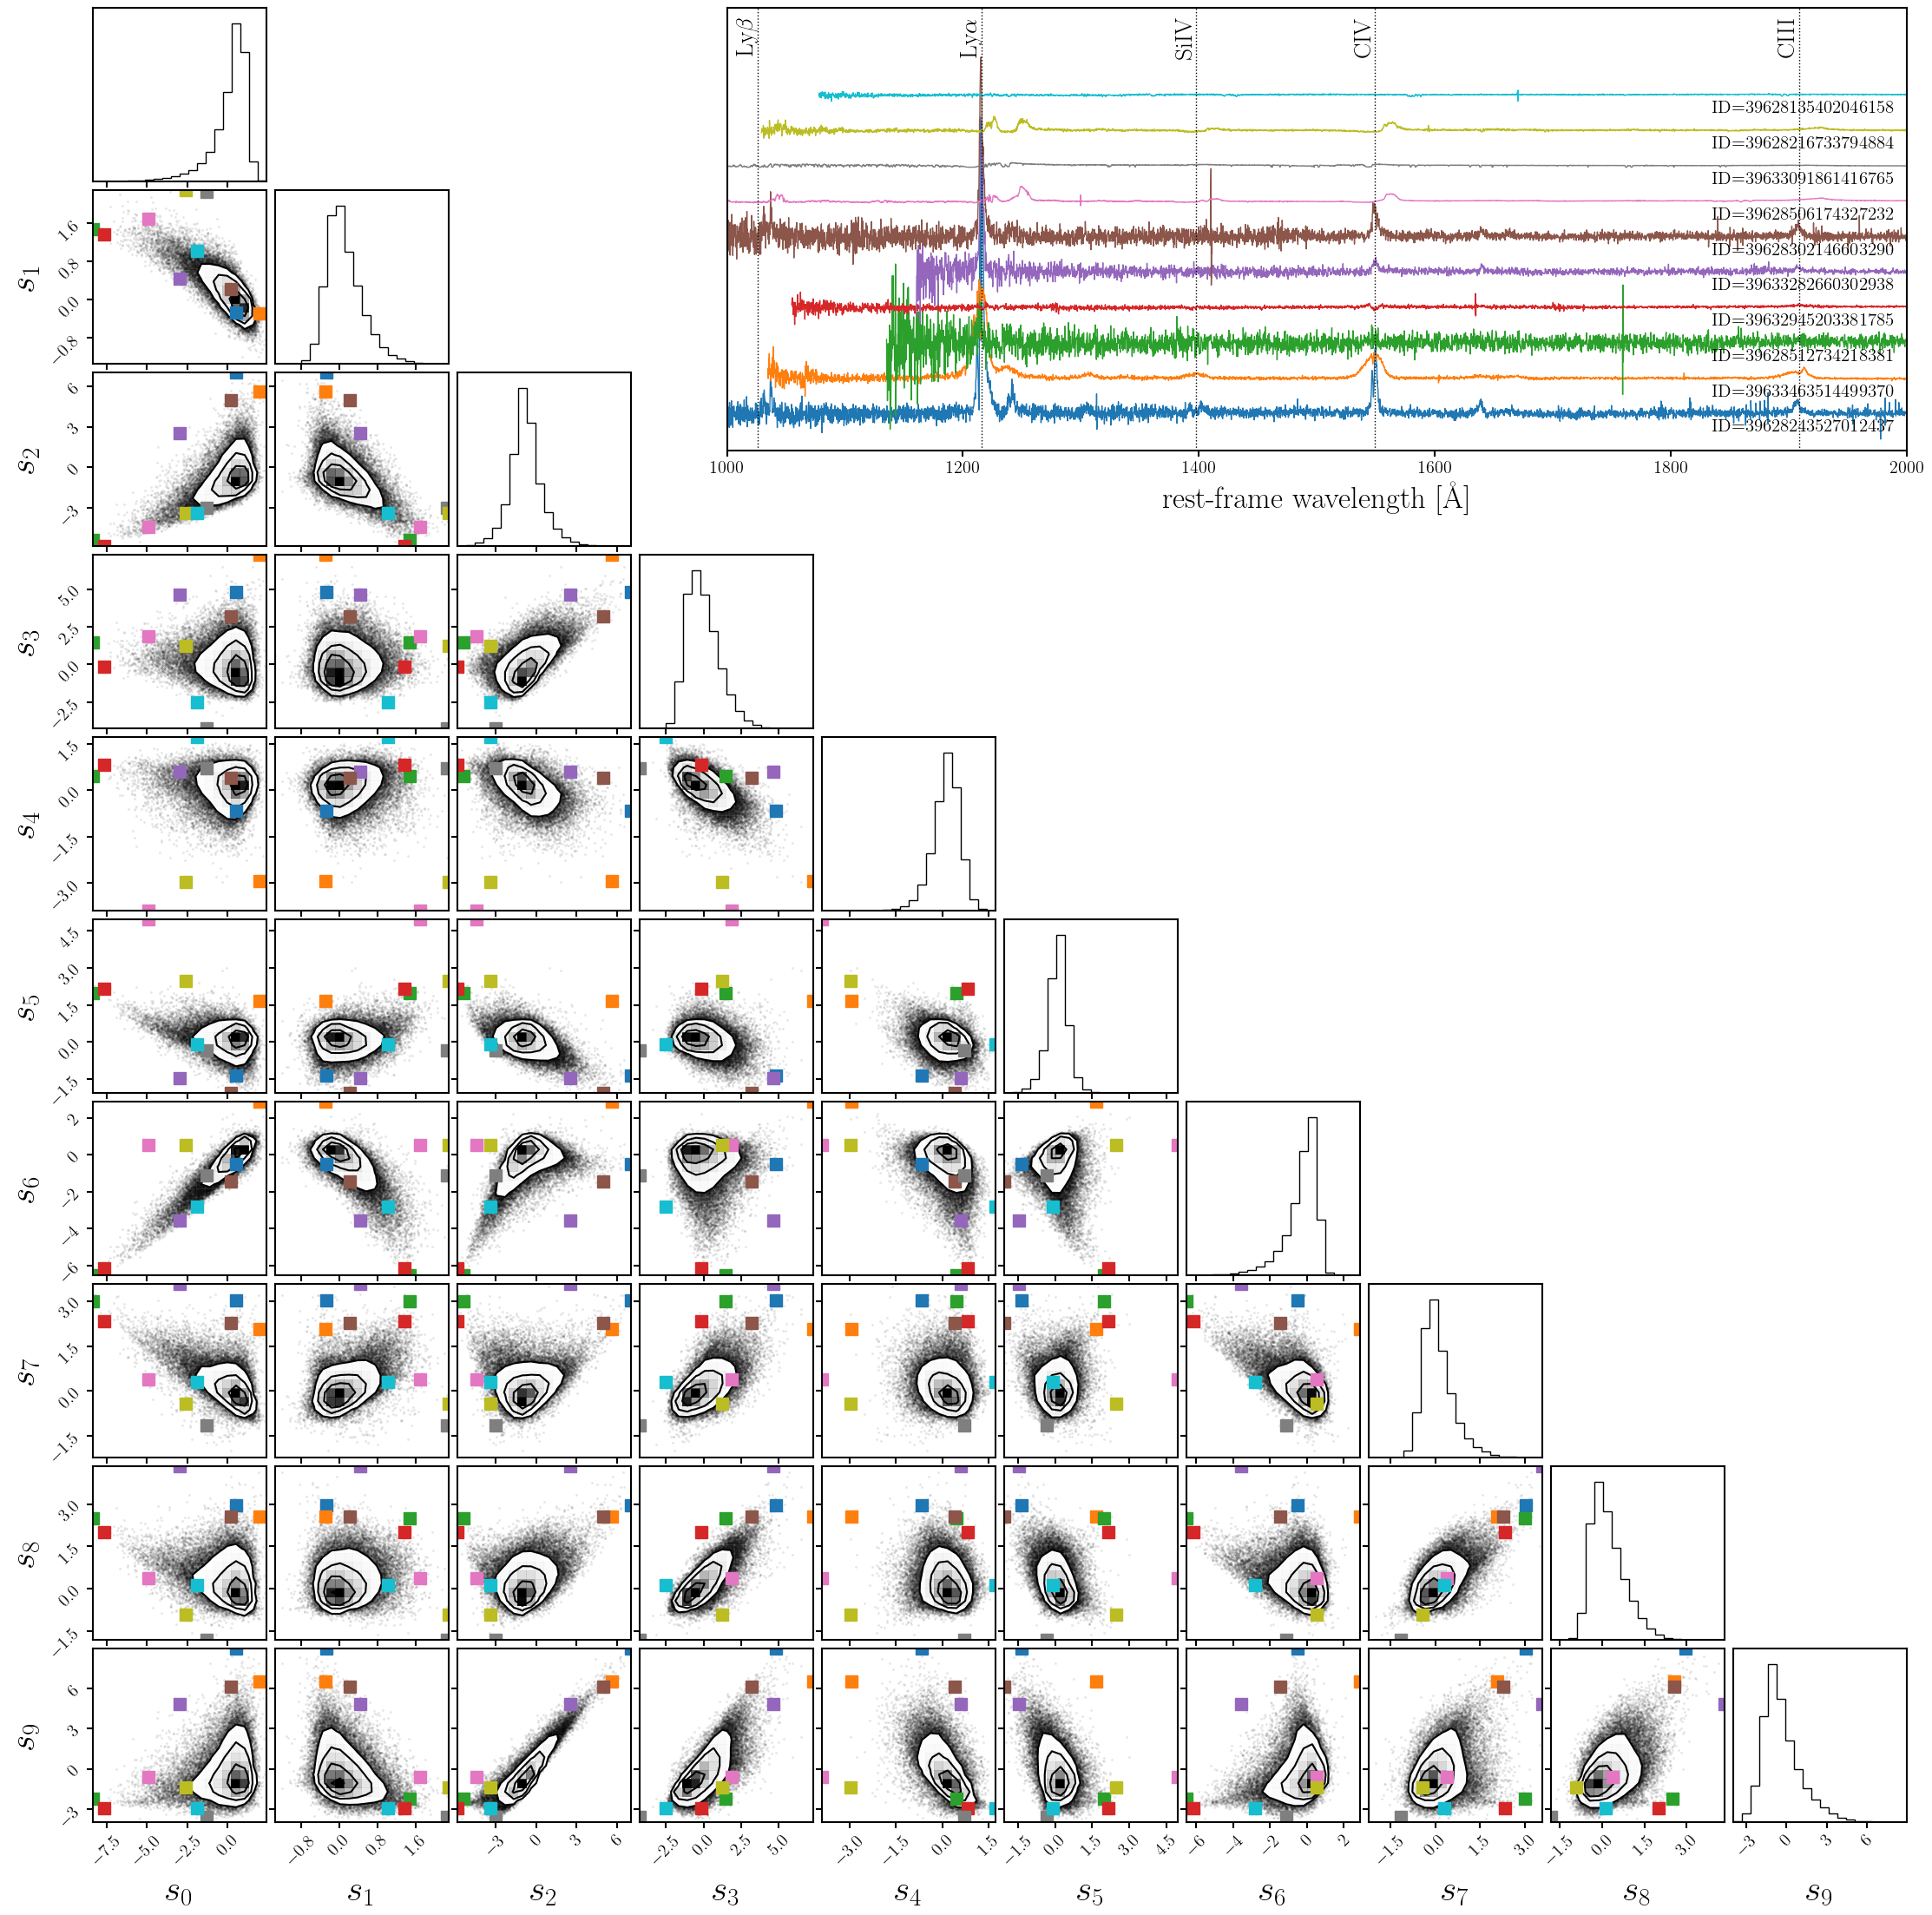

In [53]:
fig = DFM.corner(latents, color='k',
                 labels=[r'$s_{%i}$' % i for i in range(latents.shape[1])],
                 label_kwargs={'fontsize': 30})
for ii, iout in enumerate(most_outliers): 
    DFM.overplot_points(fig, [latents[iout]], color='C%i' % ii, marker='s', markersize=10)

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1,3]) 
sub = plt.subplot(gs[1])

for ii, igal in enumerate(most_outliers):
    sub.plot(np.array(models[0].wave_obs/(1.+redshifts[igal])), np.array(specs[igal,:])+20*ii, 
             c='C%i' % ii, lw=1)
    sub.text(1990, 20*ii-2, 'ID=%i' % int(tids[igal]), ha='right', va='top', fontsize=15)
    
sub.axvline(1026, color='k', linewidth=1, linestyle=':')
sub.axvline(1216, color='k', linewidth=1, linestyle=':')
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':')
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':')
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':')
#sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 225, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=20)
sub.text(1216, 225, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=20)    
sub.text(1397.61, 225, r'SiIV', rotation=90., ha='right', va='top', fontsize=20)
sub.text(1549.48, 225, r'CIV', rotation=90., ha='right', va='top', fontsize=20)
sub.text(1908.73, 225, r'CIII', rotation=90., ha='right', va='top', fontsize=20)
#sub.text(2799.12, 230, r'MgII', rotation=90., ha='right', va='top', fontsize=12)
    
sub.set_xlabel(r"rest-frame wavelength [\r{A}]", fontsize=25)    
sub.set_xlim(1000., 2000.)
sub.set_ylim(-20, 230)
sub.set_yticks([])
fig.savefig('edr_outliers.pdf', bbox_inches='tight')

In [55]:
d_outliers = np.sum((latents - np.median(latents, axis=0))**2, axis=1)

most_outliers = np.arange(latents.shape[0])[np.argsort(d_outliers)[::-1][:10]]

In [56]:
tids[most_outliers]

array([39628243527012437, 39633132034459655, 39633322460056405,
       39628211126012187, 39633463514499370, 39633132088986036,
       39633562005147668, 39627939045707569, 39628199407125141,
       39628512734218381])

[]

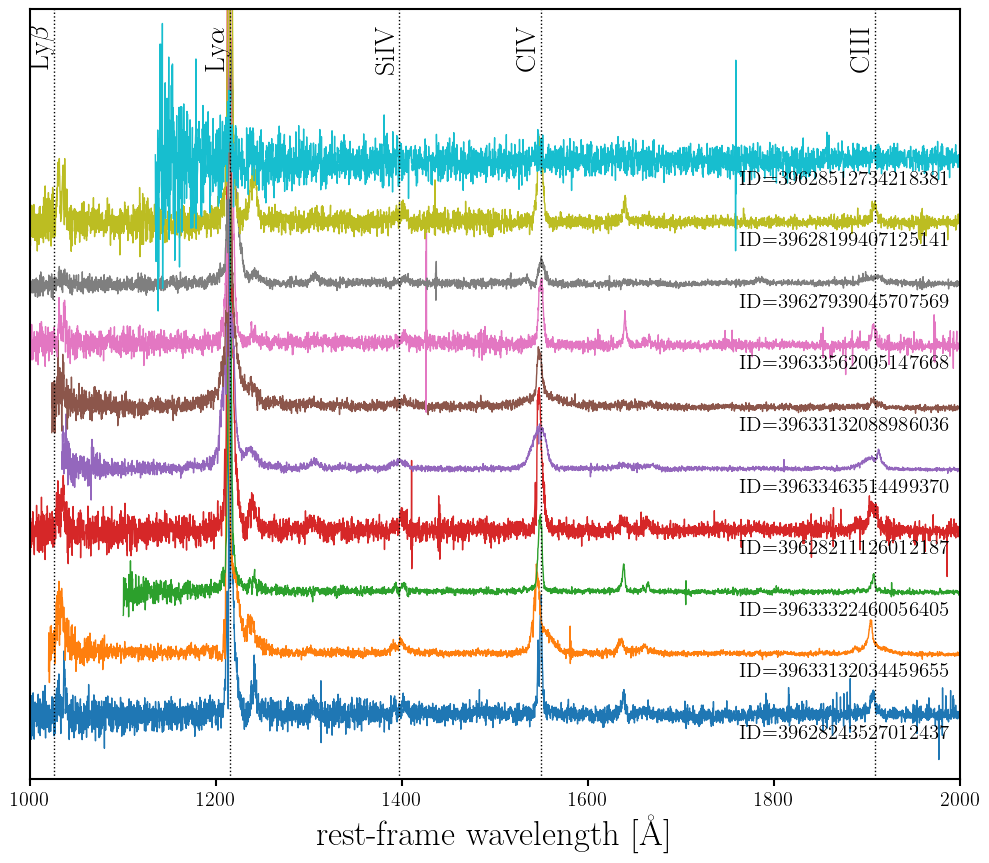

In [57]:
fig = plt.figure(figsize=(12,10))
sub = fig.add_subplot(111)
for ii, igal in enumerate(most_outliers):
    sub.plot(np.array(models[0].wave_obs/(1.+redshifts[igal])), np.array(specs[igal,:])+20*ii, 
             c='C%i' % ii, lw=1)
    sub.text(1990, 20*ii-2, 'ID=%i' % int(tids[igal]), ha='right', va='top', fontsize=15)
    
sub.axvline(1026, color='k', linewidth=1, linestyle=':')
sub.axvline(1216, color='k', linewidth=1, linestyle=':')
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':')
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':')
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':')
#sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 225, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=20)
sub.text(1216, 225, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=20)    
sub.text(1397.61, 225, r'SiIV', rotation=90., ha='right', va='top', fontsize=20)
sub.text(1549.48, 225, r'CIV', rotation=90., ha='right', va='top', fontsize=20)
sub.text(1908.73, 225, r'CIII', rotation=90., ha='right', va='top', fontsize=20)
#sub.text(2799.12, 230, r'MgII', rotation=90., ha='right', va='top', fontsize=12)
    
sub.set_xlabel(r"rest-frame wavelength [\r{A}]", fontsize=25)    
sub.set_xlim(1000., 2000.)
sub.set_ylim(-20, 230)
sub.set_yticks([])

# UMAP

In [58]:
umapper = umap.UMAP().fit(np.array(latents))

In [61]:
with open('umap_edr.p', 'wb') as f: 
    pickle.dump(umapper, f)
    
#with open('umap_edr.p', 'rb') as f: 
#    umapper = pickle.load(f)

In [5]:
with open('umap_edr.p', 'rb') as f: 
    umapper = pickle.load(f)

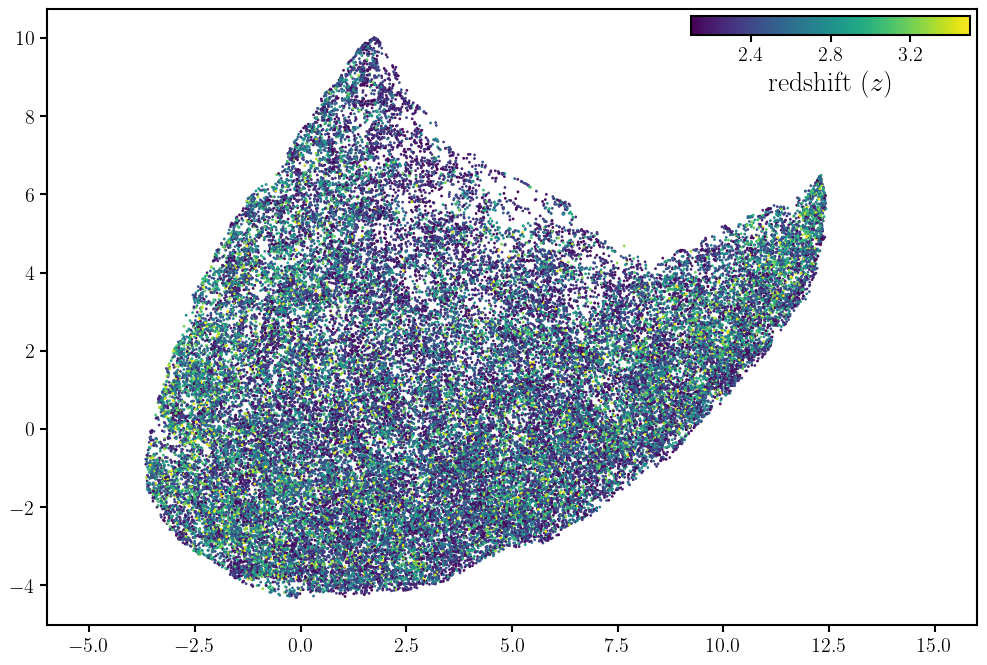

In [6]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=1,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

#sub.set_xticks([])
sub.set_xlim(-6, 16)
#sub.set_yticks([])

cbaxes = inset_axes(sub, width="30%", height="3%", loc='upper right') 
cbar = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
cbar.set_ticks([2.4, 2.8, 3.2])
cbar.set_label(label='redshift ($z$)', size=20)

In [7]:
wave_rest_rebin = np.linspace(800, 3000, 2000)

/tmp/ipykernel_513922/1353206264.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),
/tmp/ipykernel_513922/1353206264.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),


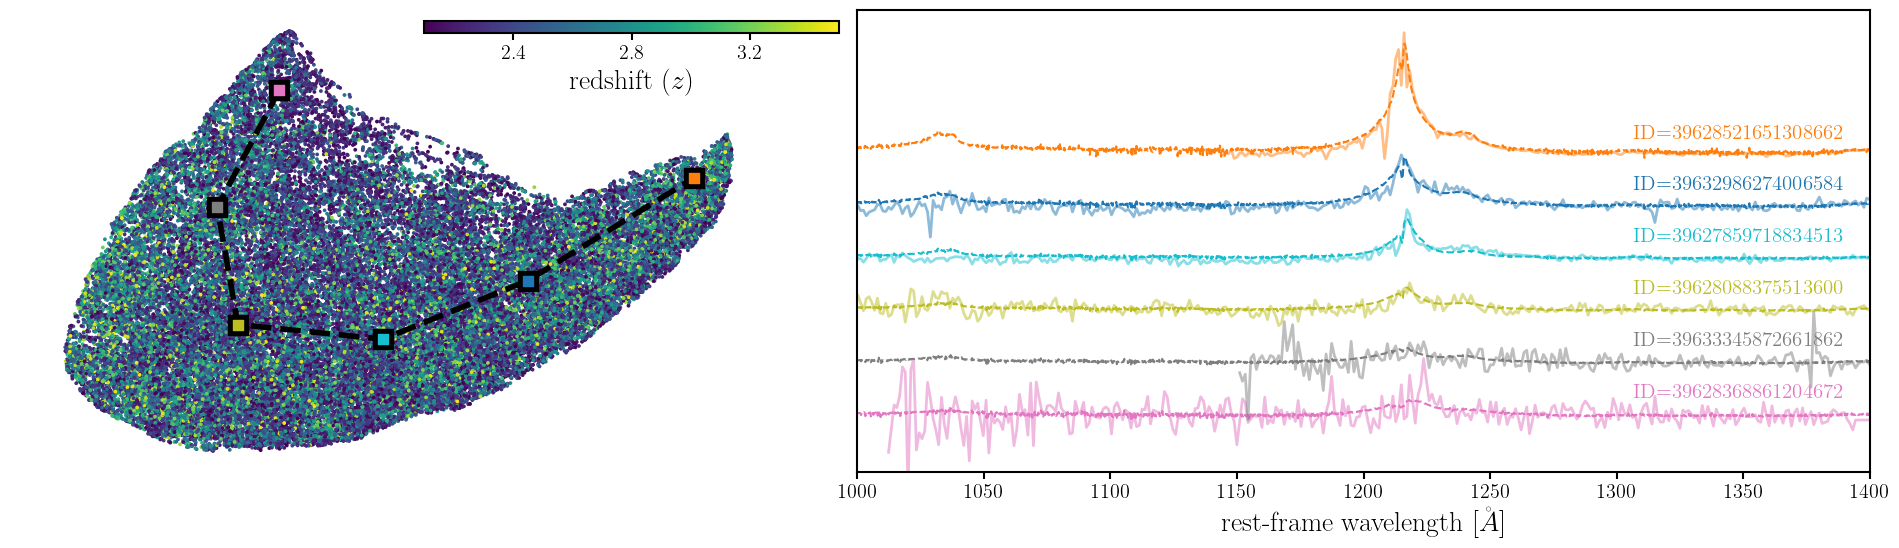

In [9]:
track = np.array([(1.5, 8.0), (0., 4.), (0.5, 0.), (4, -0.5), (7.5, 1.5), (11.5, 5)])


fig = plt.figure(figsize=(24, 6))
gs0 = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=(0.45, 0.55))

sub = plt.subplot(gs0[0])
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=3,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

for ii, point in enumerate(track): 
    sub.scatter([point[0]], [point[1]], marker='s', s=200, c='k', zorder=10)
    sub.scatter([point[0]], [point[1]], marker='s', s=50, c='C%i' % (ii+6), zorder=11)
    
sub.plot(np.array(track)[:,0], np.array(track)[:,1], c='k', ls='--', lw=4, zorder=9)

sub.set_xticks([])
sub.set_xlim(-5, 15)
sub.set_yticks([])
sub.axis('off')

cbaxes = sub.inset_axes([0.5, 0.95, 0.5, 0.025], transform=sub.transAxes) 
cbar = plt.colorbar(sc, ticks=[2.4, 2.8, 3.2], cax=cbaxes, orientation='horizontal')
cbar.set_label(label='redshift ($z$)', size=20)

sub_right = mpl.gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs0[1])

sub = plt.subplot(sub_right[0])
for ii, point in enumerate(track): 
    igal = np.argmin((umapper.embedding_[:,0] - point[0])**2 + (umapper.embedding_[:,1] - point[1])**2)
    
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(wave_rest_rebin[wlim], _spec+10*ii, c='C%i' % (ii+6), lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal]+10*ii, c='C%i' % (ii+6), ls='--')
    sub.text(1390, 10*(ii+1)-3, 'ID=%i' % int(tids[igal]), ha='right', va='top', 
             color='C%i' % (ii+6), fontsize=15)

sub.set_xlim(1000., 1400.)
sub.set_xlabel(r"rest-frame wavelength [$\AA$]", fontsize=20)
sub.set_ylim(-10., None)
sub.set_yticks([])
fig.subplots_adjust(hspace=0.05, wspace=0.02)
#fig.savefig('edr_umap.pdf', bbox_inches='tight')

In [33]:
locus0 = (np.abs(umapper.embedding_[:,0] - 1.8) < 0.2) & (umapper.embedding_[:,1] > 9.85)
locus1 = (np.abs(umapper.embedding_[:,0] - 6.25) < 0.2) & (np.abs(umapper.embedding_[:,1] - 5.5) < 0.2)
locus2 = (np.abs(umapper.embedding_[:,0] + 0.1) < 0.2) & (np.abs(umapper.embedding_[:,1] + 4.2) < 0.1)

/tmp/ipykernel_513922/175460448.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),
/tmp/ipykernel_513922/175460448.py:51: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),
/tmp/ipykernel_513922/175460448.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])),


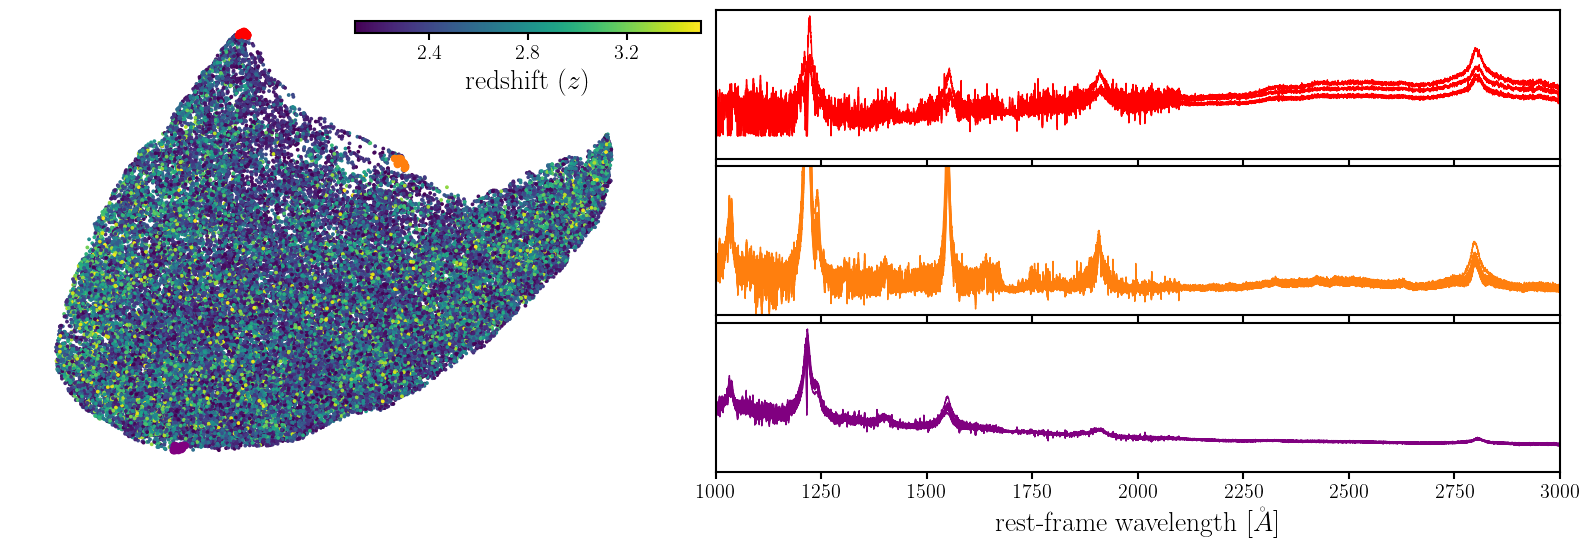

In [41]:
track = np.array([(1.5, 8.0), (0., 4.), (0.5, 0.), (4, -0.5), (7.5, 1.5), (11.5, 5)])


fig = plt.figure(figsize=(20, 6))
gs0 = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=(0.45, 0.55))

sub = plt.subplot(gs0[0])
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], s=3,
                 c=redshifts, cmap='viridis', vmin=2.1, vmax=3.5, rasterized=True)

sub.scatter(umapper.embedding_[:,0][locus0], umapper.embedding_[:,1][locus0], s=20,
                 c='r', rasterized=True)
sub.scatter(umapper.embedding_[:,0][locus1], umapper.embedding_[:,1][locus1], s=20,
                 c='C1', rasterized=True)
sub.scatter(umapper.embedding_[:,0][locus2], umapper.embedding_[:,1][locus2], s=20,
                 c='purple', rasterized=True)

sub.set_xticks([])
sub.set_xlim(-5, 15)
sub.set_yticks([])
sub.axis('off')

cbaxes = sub.inset_axes([0.5, 0.95, 0.5, 0.025], transform=sub.transAxes) 
cbar = plt.colorbar(sc, ticks=[2.4, 2.8, 3.2], cax=cbaxes, orientation='horizontal')
cbar.set_label(label='redshift ($z$)', size=20)

sub_right = mpl.gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[1])

sub = plt.subplot(sub_right[0])

for ii, igal in enumerate(np.arange(umapper.embedding_.shape[0])[locus0][:4]):
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    #sub.plot(wave_rest_rebin[wlim], _spec, c='r', lw=2, alpha=0.5)
    sub.plot(w_recon, recon[igal], c='r', ls='-', lw=1)
    #sub.text(1390, 10*(ii+1)-3, 'ID=%i' % int(tids[igal]), ha='right', va='top', 
    #         color='C%i' % (ii+6), fontsize=15)

sub.set_xlim(1000., 3000.)
sub.set_xticklabels([])
sub.set_ylim(-1., None)
sub.set_yticks([])

sub = plt.subplot(sub_right[1])

for ii, igal in enumerate(np.arange(umapper.embedding_.shape[0])[locus1][:10]):
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(w_recon, recon[igal], c='C1', ls='-', lw=1)

sub.set_xlim(1000., 3000.)
sub.set_xticklabels([])
sub.set_ylim(0., 5)
sub.set_yticks([])

sub = plt.subplot(sub_right[2])

for ii, igal in enumerate(np.arange(umapper.embedding_.shape[0])[locus2][:10]):
    wlim = ((wave_rest_rebin > np.max([900., models[0].wave_obs[0]/(1.+redshifts[igal])])+10.) & 
            (wave_rest_rebin < 1400.))
    _spec = U.trapz_rebin(np.array(models[0].wave_obs/(1.+redshifts[igal])), 
                                      np.array(specs[igal,:]), xnew=wave_rest_rebin[wlim])
    sub.plot(w_recon, recon[igal], c='purple', ls='-', lw=1)

sub.set_xlim(1000., 3000.)
sub.set_xlabel(r"rest-frame wavelength [$\AA$]", fontsize=20)
sub.set_ylim(-1., None)
sub.set_yticks([])



fig.subplots_adjust(hspace=0.05, wspace=0.02)
fig.savefig('edr_umap_demo.png', bbox_inches='tight')